In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
rho = 1.225  # sea level air density, kg/m^3
temp = 15  # standard sea level temperature, C
pressure = 101325  # standard sea level pressure, Pa
gravity = 9.80665  # acceleration of gravity, m/s^2
# Drone size
A_side = 0.04*0.4+2*0.02*0.3+0.07*0.05  # side cross section area, m^2
A_top = 0.12*0.4  # top cross section area, m^2
m_drone = 2.7  # empty drone mass, kg
# Drag Coefficient estimate for the whole drone at angle
# Common objects: 1.05=square, 
Cd = 1.0
# Power system
D_in = 11  # rotor diameter, in
num_motors = 4  # count of motors
# Energy
m_battery = 0.804  # battery mass, kg
batt_volt = 4*3.5  # battery nominal voltage, V
batt_Ah = 10  # battery capacity, Ah
batt_C_rate = 10  # battery C rating, C
# Payload
m_payload = 0.8  # payload mass, kg

# Calculations
batt_Wh = batt_volt*batt_Ah  # watt-hours, Wh
print(f"Battery Wh: {batt_Wh:.2f} Wh")
batt_energy = batt_Wh*3600  # energy, J
print(f"Battery energy: {batt_energy:.0f} J")
batt_energy_density = batt_Wh/m_battery  # energy density, Wh/kg
print(f"Battery energy density: {batt_energy_density:.2f} Wh/kg")
batt_max_watt = batt_volt*batt_Ah*batt_C_rate
print(f"Battery maximum wattage: {batt_max_watt:.2f} W")
D_m = 0.0254*D_in # rotor diameter, m
A_rotors = num_motors * 0.25*np.pi*D_m**2  # area of the rotors, m^2
print(f"Total rotor area: {A_rotors:.4f} m^2")
A_top += A_rotors # add the rotor area to the top area, m^2
print(f"Top Area: {A_top:.4f} m^2")
print(f"Side Area: {A_side:.4f} m^2")
m_total = m_drone+m_battery+m_payload  # total mass, kg
print(f"Total Mass: {m_total:.4f} kg")
w_total = gravity*m_total  # total weight, N
print(f"Total Weight: {w_total:.4f} N")
# terminal_velocity = np.sqrt(w_total/(0.5*rho*A_top*Cd))
# print(f"Terminal Velocity: {terminal_velocity:.4f} m/s")

Battery Wh: 140.00 Wh
Battery energy: 504000 J
Battery energy density: 174.13 Wh/kg
Battery maximum wattage: 1400.00 W
Total rotor area: 0.2452 m^2
Top Area: 0.2932 m^2
Side Area: 0.0315 m^2
Total Mass: 4.3040 kg
Total Weight: 42.2078 N


In [3]:
# hovering
v_s = np.sqrt( (2*w_total) / (A_rotors*rho) )
print(f"Air exit velocity: {v_s:.4f} m/s")
power_hover = np.sqrt( (w_total)**3 / (2*A_rotors*rho) )
print(f"Power to hover: {power_hover:.2f} watts")
hover_time = batt_energy/power_hover/60
print(f"Max hover time: {hover_time:.2f} minutes")

Air exit velocity: 16.7626 m/s
Power to hover: 353.76 watts
Max hover time: 23.75 minutes


Efficent climb rate is 6.88 m/s (153.56 J/m) drawing 1057.06 W


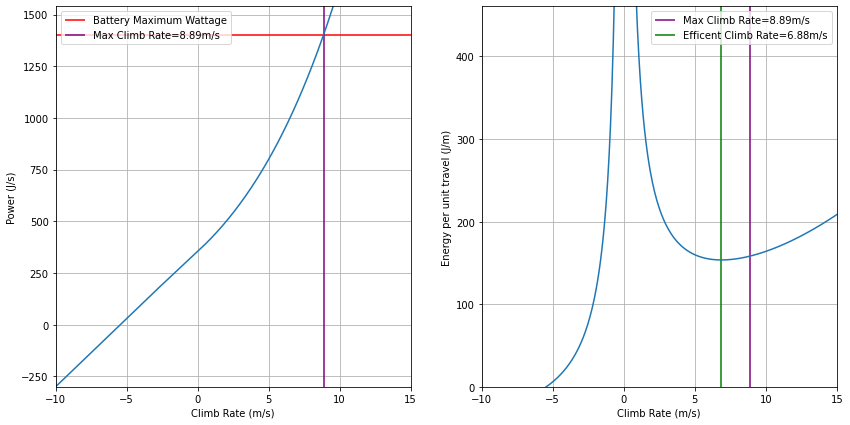

In [4]:
# climbing at constant velocity
min_climb=-10
max_climb=15
climb_rate = np.linspace(min_climb, max_climb, 500)

def constant_climbing(climb_rate):
    # Climbing requires to lift the weight and overcome drag
    drag_force = np.sign(climb_rate)*0.5*rho*A_top*Cd*climb_rate**2
    climb_thrust = drag_force+w_total
    # Wake velocity is calculated from the pressure drop over the rotor and bernoulli's equation
    wake_velocity = np.sqrt( (2*climb_thrust)/(rho*A_rotors) + climb_rate**2)
    # Using thrust equations from pressure and momentum, this relation is derived
    rotor_velocity = 0.5*(climb_rate+wake_velocity)
    # Power is the KE imparted on the air and the change in potential energy.
    power = 0.5*rho*A_rotors*rotor_velocity*wake_velocity**2 + w_total*climb_rate
    return power

power = constant_climbing(climb_rate)

# power is J/s and the time is related to s=m/v, so P/v is energy per distance or J/m
energy_per_distance = power/abs(climb_rate)

# Maximum speed is limited by power
max_climb_Rate = climb_rate[np.argmax(power>batt_max_watt)]

min_arg = np.argmin(energy_per_distance[climb_rate>0])
min_energy_per_distance = energy_per_distance[climb_rate>0][min_arg]
min_climb_rate = climb_rate[climb_rate>0][min_arg]
min_power = power[climb_rate>0][min_arg]

print(f"Efficent climb rate is {min_climb_rate:.2f} m/s ({min_energy_per_distance:.2f} J/m) drawing {min_power:.2f} W")

fig = plt.figure(figsize=(14,7))
ax1, ax2 = fig.subplots(nrows=1, ncols=2)
ax1.plot(climb_rate, power)
ax1.hlines(y=batt_max_watt, xmin=min_climb, xmax=max_climb, colors='red', label="Battery Maximum Wattage")
ymin=np.min(power); ymax=1.1*batt_max_watt
ax1.vlines(x=max_climb_Rate, ymin=ymin, ymax=ymax, colors='purple', label=f"Max Climb Rate={max_climb_Rate:.2f}m/s")
ax1.set_ylim([ymin, ymax]); ax1.set_xlim([min_climb, max_climb])
ax1.grid(); ax1.set_ylabel("Power (J/s)"); ax1.set_xlabel("Climb Rate (m/s)"); ax1.legend()

ax2.plot(climb_rate, energy_per_distance)
ymin=0; ymax=3*min_energy_per_distance
ax2.vlines(x=max_climb_Rate, ymin=ymin, ymax=ymax, colors='purple', label=f"Max Climb Rate={max_climb_Rate:.2f}m/s")
ax2.vlines(x=min_climb_rate, ymin=ymin, ymax=ymax, colors='green', label=f"Efficent Climb Rate={min_climb_rate:.2f}m/s")
ax2.set_ylim([ymin, ymax]); ax2.set_xlim([min_climb, max_climb])
ax2.grid(); ax2.set_ylabel("Energy per unit travel (J/m)"); ax2.set_xlabel("Climb Rate (m/s)"); ax2.legend()


In [5]:
constant_climbing(2.5)

540.8430795538214

In [6]:
def rot_mat(degrees):
    theta = np.radians(degrees)
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c, s), (s, c)))

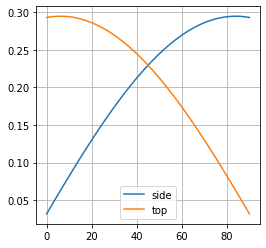

In [7]:
angles = np.linspace(0,90,100)
area_vector = np.array([A_side, A_top]).reshape(2,1)
area_rotated = rot_mat(angles).T.dot(area_vector).reshape(-1, 2)
fig = plt.figure(figsize=(4,4))
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(angles, area_rotated[:,0], label="side")
ax.plot(angles, area_rotated[:,1], label="top")
ax.grid(); ax.legend()

C:\Users\Luke A Sargen\Anaconda3\envs\uas\lib\site-packages\IPython\core\interactiveshell.py:3361: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\LUKEAS~1\AppData\Local\Temp/ipykernel_25276/1837794302.py:50: RuntimeWarning: divide by zero encountered in true_divide
  energy_per_distance = power/abs(forward_airspeed)


iter=34 diff=8.099689245000263e-05
894.9168546252997
Energy used at 12.05 m/s: 678.334168801444 mah/km


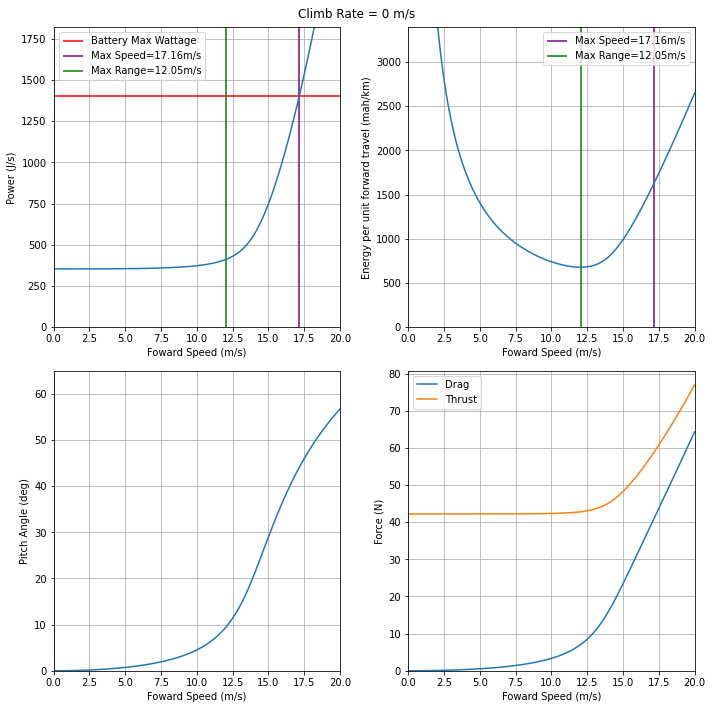

In [8]:
# foward flight at a constant velocity, no altitude change
min_airspeed = 0
max_airspeed = 20
points = 1000
forward_airspeed = np.linspace(min_airspeed, max_airspeed, points)  # m/s
climb_rate = 0 # m/s
# 2d airspeed where [vx, vy]
velocity_airspeed = np.stack(np.broadcast(forward_airspeed, climb_rate), axis=0)
# area vector that can be rotated [A_side, A_top]
area_vector = np.array([A_side, A_top]).reshape(2,1)
# Initial estimated pitch is 45 deg
pitch_angle = np.full(points, 45)
# Estimate the pitch angle by using the estimated drag and weight to update the thrust angle needed
for iter in range(50):
    # Rotation to be [new_side, new_top]
    area_rotated = rot_mat(pitch_angle).T.dot(area_vector).reshape(-1, 2)
    # Estimate the drag at each angle based on airspeed
    drag = 0.5*rho*area_rotated*Cd*velocity_airspeed**2
    required_thrust = np.copy(drag)
    required_thrust[:,1] += w_total
    # Estimate the new angle using the side drag and the top drag+weight
    blend = 0.8  # percentage of the new estimate to update with
    new_angles = (1-blend)*pitch_angle + blend*np.degrees(np.arctan(required_thrust[:,0]/(required_thrust[:,1])))
    diff = np.max(abs(new_angles-pitch_angle))
    pitch_angle = new_angles
    # If the maximum change in the angles is very small, it's basically converged to a decent angle
    if diff < 1e-4: break
print(f"{iter=} {diff=}")

thrust_mag = np.linalg.norm(required_thrust, axis=1)
drag_mag = np.linalg.norm(drag, axis=1)
airspeed_mag = np.linalg.norm(velocity_airspeed, axis=1)
airspeed_angle = np.nan_to_num(np.degrees(np.arctan2(velocity_airspeed[:,0],(velocity_airspeed[:,1]))), nan=90)
# This is the angle the incoming airspeed vector makes with the thrust vector
relative_angle = airspeed_angle-pitch_angle
# This should probably be the mass flow through the rotor disk, but that's too much work for right now
axial_airspeed = airspeed_mag*np.cos(np.radians(relative_angle))

# Wake velocity is calculated from the pressure drop over the rotor and bernoulli's equation
wake_velocity = np.sqrt( (2*thrust_mag)/(rho*A_rotors) + axial_airspeed**2)
# Using thrust equations from pressure and momentum, this relation is derived
rotor_velocity = 0.5*(axial_airspeed+wake_velocity)
# Power is the KE imparted on the air and the change in potential energy
power = 0.5*rho*A_rotors*rotor_velocity*wake_velocity**2  + w_total*climb_rate

# Maximum speed is limited by power
max_spd = forward_airspeed[np.argmax(power>batt_max_watt)]

# power is J/s and the time is related to s=m/v, so P/v is energy per distance or J/m
energy_per_distance = power/abs(forward_airspeed)
# convert J/m to mah/km
energy_per_distance = 1000*energy_per_distance/(3.6*batt_volt)

maximum_range_airspeed = forward_airspeed[np.argmin(energy_per_distance)]

print( energy_per_distance[np.argmax(forward_airspeed>8)] )
print(f"Energy used at {maximum_range_airspeed:.2f} m/s: {energy_per_distance[np.argmin(energy_per_distance)]} mah/km")

fig = plt.figure(figsize=(10,10))
(ax1, ax2), (ax3, ax4) = fig.subplots(nrows=2, ncols=2)
fig.suptitle(f"Climb Rate = {climb_rate} m/s")

ax1.plot(forward_airspeed, power)
ymin=0; ymax=1.3*batt_max_watt
ax1.hlines(y=batt_max_watt, xmin=min_airspeed, xmax=max_airspeed, colors='red', label="Battery Max Wattage")
ax1.vlines(x=max_spd, ymin=ymin, ymax=ymax, colors='purple', label=f"Max Speed={max_spd:.2f}m/s")
ax1.vlines(x=maximum_range_airspeed, ymin=ymin, ymax=ymax, colors='green', label=f"Max Range={maximum_range_airspeed:.2f}m/s")
ax1.set_ylim([ymin,ymax])
ax1.set_xlim([min_airspeed, max_airspeed])
ax1.grid(); ax1.set_ylabel("Power (J/s)"); ax1.set_xlabel("Foward Speed (m/s)"); ax1.legend()

ax2.plot(forward_airspeed, energy_per_distance)
ymin=0; ymax=5*np.min(energy_per_distance[energy_per_distance!=np.inf])
ax2.vlines(x=max_spd, ymin=ymin, ymax=ymax, colors='purple', label=f"Max Speed={max_spd:.2f}m/s")
ax2.vlines(x=maximum_range_airspeed, ymin=ymin, ymax=ymax, colors='green', label=f"Max Range={maximum_range_airspeed:.2f}m/s")
ax2.set_ylim([ymin, ymax])
ax2.set_xlim([min_airspeed, max_airspeed])
ax2.grid(); ax2.set_ylabel("Energy per unit forward travel (mah/km)"); ax2.set_xlabel("Foward Speed (m/s)"); ax2.legend()

ax3.plot(forward_airspeed, pitch_angle)
ylim=0; ymax=65
ax3.set_ylim([ymin, ymax])
ax3.set_xlim([min_airspeed, max_airspeed])
ax3.grid(); ax3.set_ylabel("Pitch Angle (deg)"); ax3.set_xlabel("Foward Speed (m/s)")

ax4.plot(forward_airspeed, drag_mag, label="Drag")
ax4.plot(forward_airspeed, thrust_mag, label="Thrust")
ax4.set_ylim(bottom=0)
ax4.set_xlim([min_airspeed, max_airspeed])
ax4.grid(); ax4.set_ylabel("Force (N)"); ax4.set_xlabel("Foward Speed (m/s)"); ax4.legend()

fig.tight_layout()
fig.patch.set_facecolor('white')
plt.savefig(f"climb_rate_{climb_rate:.1f}.png", bbox_inches="tight", transparent=False)

In [9]:
# max range: veolcity with minium energy per distance
# max endurance: velocity with minimum power, does no exist for vtol, but does for planes